## Facial Emotion Recognition

### 1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D
import os
import seaborn as sns 
from sklearn.metrics import confusion_matrix
import cv2

### 2. Load Dataset

In [2]:
#Load training datapath
train_data = './Facial Images/train/'

#Load validation datapath
validation_data = './Facial Images/validation/'

### 3. Data Exploration and Preprocessing

In [3]:
#Display the total number of expressions and its count in training data
total_images_train = 0
for expression in os.listdir(train_data):
    print(expression, " ", len(os.listdir(train_data + expression)))
    total_images_train = total_images_train + len(os.listdir(train_data + expression))
print("Number of Images in Training Set", total_images_train)

angry   3995
disgust   436
fear   4097
happy   7215
neutral   4965
sad   4830
surprise   3171
Number of Images in Training Set 28709


In [4]:
#Display the total number of expressions in validation set and create an array of emotions
emotions = []
total_images_val = 0
for expression in os.listdir(validation_data):
    print(expression, " ", len(os.listdir(validation_data + expression)))
    image_data = [expression]
    total_images_val = total_images_val + len(os.listdir(validation_data + expression))
    emotions.append(image_data)
print("Number of Images in Validation Set", total_images_val)
print("\n Array of Emotions", emotions)

angry   960
disgust   111
fear   1018
happy   1825
neutral   1216
sad   1139
surprise   797
Number of Images in Validation Set 7066

 Array of Emotions [['angry'], ['disgust'], ['fear'], ['happy'], ['neutral'], ['sad'], ['surprise']]


### 4. Display Emotion Categories along with Images

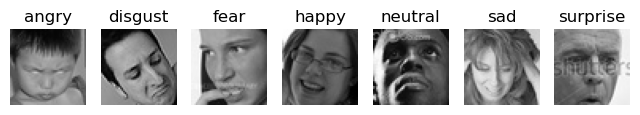

In [5]:
#Loop through the emotions
i = 1
plt.figure(figsize=(8,8))
#loop through the training data and load the images from each expression
for expression in os.listdir(train_data):
    images = load_img((train_data + expression) + '/' + os.listdir(train_data + expression)[0])
    plt.subplot(1,7,i)
    plt.imshow(images)
    plt.title(expression)
    plt.axis('off')
    i = i + 1

### 5. Data Augmentation

CNN itself does not take care of rotation and scaling, so a ratio of sample images from the training set has to be roatated and scaled, for which data augmentation methods can be used.

In [6]:
#Generating Training Dataset using data augmentation
generate_train_data = ImageDataGenerator()

training_dataset = generate_train_data.flow_from_directory(train_data, shuffle=True, target_size=(48,48),
                                                          color_mode = 'grayscale', class_mode = 'categorical', batch_size=128)

Found 28709 images belonging to 7 classes.


In [7]:
#Generate Validation Dataset using data augmentation
generate_validation_data = ImageDataGenerator()

validation_dataset = generate_train_data.flow_from_directory(validation_data, shuffle=True, target_size=(48,48),
                                                          color_mode = 'grayscale', class_mode = 'categorical', batch_size=128)

Found 7066 images belonging to 7 classes.


### 6. Model Creation

In [8]:
#Initializes a sequential model where layers are stacked on top of each other.
model = models.Sequential()

#Layers #1 - Conv2D - layer that applies convolution operation to the input
#Number of filters - 64
#Kernel/filter size = convolution window of (3*3)
#Padding - Addition of extra pixels for input images - remains the same 
#Activation function - ReLU - for linearity and fastens the training and computation
#Input shape - (48,48,1) - Specifies the shape of the input image (48x48 pixels, 1 channel for grayscale).

model.add(Input(shape=(48, 48, 1)))
model.add(layers.Conv2D(64, (3,3), padding = 'same', activation='relu'))

#Normalizes the output of the previous activation layer for improving the speed and stability
model.add(layers.BatchNormalization())

#By creating feature maps, reduces the dimensions (2*2) by extracting the maximum number, computation and overfitting
model.add(layers.MaxPooling2D(pool_size=(2,2)))

#Dropout rate - 0.25 - which is randomly set to avoid overfitting
model.add(layers.Dropout(0.25))

#layer 2
#Number of filters - 128
#Kernel/filter size = convolution window of (5*5)
model.add(layers.Conv2D(128, (5,5), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#To avoid overfitting
model.add(layers.Dropout(0.25))

#layer 3
#Number of filters - 256
#Kernel/filter size = convolution window of (3*3)
model.add(layers.Conv2D(256, (3,3), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#To avoid overfitting
model.add(layers.Dropout(0.25))

#layer 4
#Number of filters - 512
#Kernel/filter size = convolution window of (3*3)
model.add(layers.Conv2D(512, (3,3), padding = 'same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
#To avoid overfitting
model.add(layers.Dropout(0.25))

#Flattens the input to a 1D array which is necessary before feeding it to the fully connected layers.
model.add(layers.Flatten())

#Fully connected layers.
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.25))

#Number of neurons - 7, Softmax - used for output layer since it is a multi-class classification problem
model.add(layers.Dense(7, activation='softmax'))

### 7. Model Summary

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 2,311,047 (8.82 MB)

 Trainable params: 2,308,359 (8.81 MB)

 Non-trainable params: 2,688 (10.50 KB)

### 8. Model Compilation

In [10]:
#Loss function - categorical cross-entropy, suitable for multi-class classification.
#Adam Optimizer - learning rate of 0.0001, which adapts the learning rate during training.
#Metrics -Accuracy
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### 9. Model Training

In [11]:
#fit - trains the model for 50 epochs
history = model.fit(training_dataset, validation_data = validation_dataset, epochs=50, batch_size = 128, verbose = 1)

Epoch 1/50


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.2610 - loss: 1.9228 - val_accuracy: 0.4083 - val_loss: 1.5780
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4354 - loss: 1.4729 - val_accuracy: 0.5228 - val_loss: 1.2518
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 207s 921ms/step - accuracy: 0.5131 - loss: 1.2713 - val_accuracy: 0.5440 - val_loss: 1.1735
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 211s 938ms/step - accuracy: 0.5558 - loss: 1.1593 - val_accuracy: 0.5655 - val_loss: 1.1618
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 211s 938ms/step - accuracy: 0.5855 - loss: 1.0875 - val_accuracy: 0.6219 - val_loss: 0.9954
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 212s 942ms/step - accuracy: 0.6086 - loss: 1.0288 - val_accuracy: 0.6683 - val_loss: 0.8890
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 213s 944ms/step - accuracy: 0.6348 - loss: 0.9621 - val_accuracy: 0.6809 - val_loss: 0.8665
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 212s 942ms/step - accuracy: 0.6558 - loss: 0.9088 - v

### 10. Save the Model

In [12]:
from tensorflow.keras.models import load_model
model.save('FacialExpressionRecognitionModel.keras')

### 11. Plot - Training and Validation Loss and Accuarcy

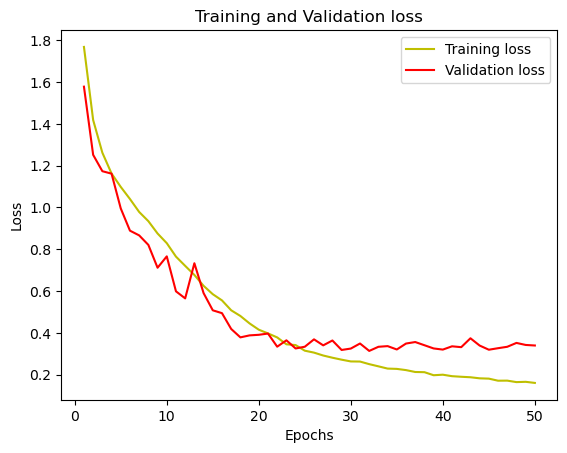

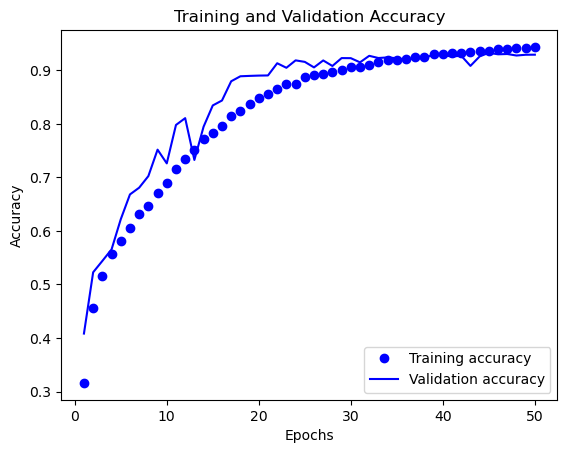

In [14]:
#Plot for training and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'y', label='Training loss')
plt.plot(epochs, validation_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Plot for training and validation accuracy
train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### 12. Confusion Matrix

56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step


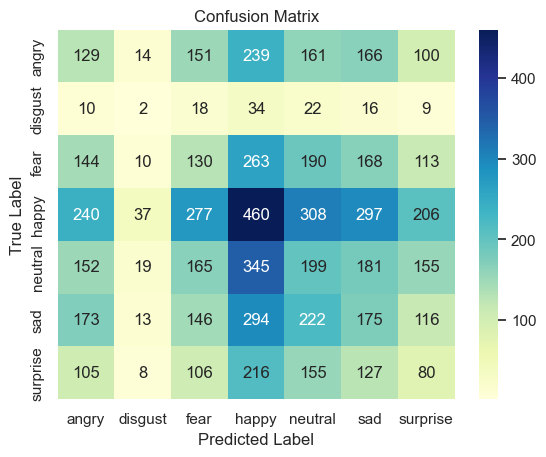

In [20]:
#Compute confusion matrix on validation data, so that it helps understanding performance during training
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = validation_dataset.classes
validation_pred_probs = model.predict(validation_dataset)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(training_dataset.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### 13. Test Model

In [19]:
#Load the model
model = tf.keras.models.load_model('FacialExpressionRecognitionModel.keras')

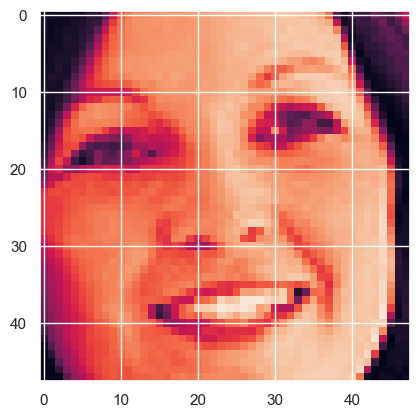

In [24]:
#Testing with images
test_image = cv2.imread('TestData/Happy.jpg')[:,:,0]
plt.imshow(test_image)
#resize the image
test_image = cv2.resize(test_image, (48, 48))
test_image = np.invert(np.array([test_image]))

In [25]:
#Predict the result
result = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [26]:
data = emotions[np.argmax(result)]
print(data)

['happy']
